In [9]:
from google.colab import drive
import os, shutil
drive.mount('/content/drive/')
n_recycles = 24

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [10]:
input_dir = '/content/drive/MyDrive/EpiFold2/files/fasta_files'
result_dir = f'/content/drive/MyDrive/EpiFold2/files/results_{n_recycles}'

zip_files = [os.path.join(result_dir, f) for f in os.listdir(result_dir) if (f.endswith('.zip') and len(f.split('.')[0]) == 4)]

for zip_file in zip_files:
    shutil.unpack_archive(zip_file, result_dir)

In [23]:
n_recycles = 24

In [50]:
import pandas as pd
def extract_info_from_pdb(path):
  with open(path, 'r') as f:
    lines = f.readlines()
  if 'bfact' in path:
    column_headers = [
    "ATOM", "serial", "atom_name", "residue_name",
    "chainID", "residue_number", "X", "Y", "Z", "occupancy",
    "B-factor", "disterror"
    ]
  else:
    column_headers = [
    "ATOM", "serial", "atom_name", "residue_name",
    "chainID", "residue_number", "X", "Y", "Z", "occupancy",
    "B-factor", "element"
    ]
  struct_info = pd.DataFrame(columns=column_headers)
  for line in lines:
    if 'ATOM' in line[0:6]:
      #print(line)
      content = line.split()

      atom = content[0].strip()
      serial = int(content[1].strip())
      atomname = content[2].strip()
      residname = content[3].strip()
      chainid = content[4].strip()
      #residuenum = ''
      if len(chainid) != 1:
        residuenum = chainid[1:].strip()
        chainid = chainid[0].strip()
        x = content[5].strip()
        y = content[6].strip()
        z = content[7].strip()
        edit = content[8]
        occ = edit[:4].strip()
        try:
          bfact = float(edit[4:].strip())
        except:
          bfact = 0
        elem = content[9].strip()
      else:
        residuenum = content[5].strip()
        x = content[6].strip()
        y = content[7].strip()
        z = content[8].strip()
        edit = content[9]
        if edit != '1.00':
          occ = edit[:4].strip()
          try:
            bfact = float(edit[4:].strip())
          except:
            bfact = 0
          elem = content[10].strip()
        else:
          occ = edit
          try:
            bfact = float(content[10])
          except:
            bfact = 0
          elem = content[11]


      temp = pd.DataFrame([[atom, serial, atomname, residname, chainid, residuenum, x, y, z, occ, bfact, elem]], columns=column_headers)
      struct_info = pd.concat([struct_info, temp])

  struct_info_indexed = struct_info.reset_index()
  struct_info_indexed = struct_info_indexed.drop(columns='index')

  return struct_info_indexed

In [97]:
def get_b_factors(exp_pdb_path): # return the b-factors from a pdb
  pdb_info = extract_info_from_pdb(exp_pdb_path)
  b_factors = list(pdb_info[pdb_info['atom_name'] == 'N']['B-factor'])
  return b_factors

def get_exp_b_factors(input_dir): # return all experimental b-factors given alphafold input (backtracks the fastas to experimental pdbs and gets b-factors)
  pdbs_path = os.path.join(input_dir.split('/fasta_files')[0], 'pdb files')
  pdb_paths = [os.path.join(pdbs_path, f) for f in os.listdir(pdbs_path)][:5] # TRIMMING TO FIRST 5 FOR TESTING
  exp_b_factor_list = []
  for exp_pdb_path in pdb_paths:
    exp_b_factors = get_b_factors(exp_pdb_path)
    exp_b_factor_list.append(exp_b_factors)
  return exp_b_factor_list

def get_plddts(result_dir):
  pdb_paths = [os.path.join(result_dir,f) for f in os.listdir(result_dir) if (f.endswith('.pdb') and f'{n_recycles}r' in f)][:5] # TRIMMING TO 5 FOR TESTING
  af_plddt_list = []
  for af_plddt_path in pdb_paths:
    af_plddt = get_b_factors(af_plddt_path)
    af_plddt_list.append(af_plddt)
  return af_plddt_list

exp_b_factor_list = get_exp_b_factors(input_dir)

In [115]:
def b_factors(input_dir): # return all experimental b-factors given alphafold input (backtracks the fastas to experimental pdbs and gets b-factors)
  pdbs_path = os.path.join(input_dir.split('/fasta_files')[0], 'pdb files')
  pdb_path = [os.path.join(pdbs_path, f) for f in os.listdir(pdbs_path)][0] # TRIMMING TO FIRST 5 FOR TESTING
  exp_b_factors = get_b_factors(pdb_path)
  return exp_b_factors

In [214]:
import numpy as np

40

/content/drive/MyDrive/EpiFold2/files/pdb files/4CDB.pdb
4CDB
4CDB


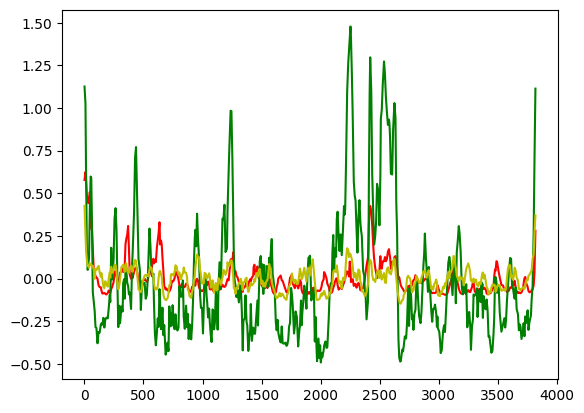

In [376]:
import numpy as np
pdb = '1234'
pdb_ids_check = ['4L79', '3LZG', '6DNP', '2CMZ', '4CDB', '3CYE', '1DQZ', '1PC3', '1CU1']
while pdb.split('/')[-1].split('.')[0] not in pdb_ids_check:
  pdbs_path = os.path.join(input_dir.split('/fasta_files')[0], 'pdb files')
  all_pdbs = [os.path.join(pdbs_path, f) for f in os.listdir(pdbs_path)]
  num_file = np.random.randint(len(all_pdbs))
  pdb = all_pdbs[num_file]
print(pdb)
pdb_info = extract_info_from_pdb(pdb)
exp_N_atom = pdb_info[pdb_info['atom_name'] == 'N']
exp_n_b_factors = list(exp_N_atom[exp_N_atom['chainID'] == 'A']['B-factor'])

pdb_id = pdb.split('/')[-1].split('.')[0]
af_pdbs = [os.path.join(result_dir,f) for f in os.listdir(result_dir) if (f.endswith('.pdb') and f'{n_recycles}r' in f)]
af_pdb_path = [f for f in af_pdbs if pdb_id in f][0]
af_info = extract_info_from_pdb(af_pdb_path)
af_N_atom = af_info[af_info['atom_name'] == 'N']
af_n_b_factors = list(af_N_atom[af_N_atom['chainID'] == 'A']['B-factor'])

exp_N_atom.set_index('serial', inplace=True)
af_N_atom.set_index('serial', inplace=True)

comparison_table = pd.DataFrame(columns=['exp B-factor', 'af B-factor'])
for serial_n in af_N_atom.index:
  if serial_n in exp_N_atom.index:
    try:
      comparison_table.loc[serial_n, 'exp B-factor'] = (exp_N_atom['B-factor'].loc[serial_n] - exp_N_atom['B-factor'].mean())/exp_N_atom['B-factor'].mean()
      comparison_table.loc[serial_n, 'af B-factor'] = -1*(af_N_atom['B-factor'].loc[serial_n] - af_N_atom['B-factor'].mean())/af_N_atom['B-factor'].mean()
    except:
      pass

import requests, tarfile

print(pdb_id)
results_urls_table = pd.read_csv('/content/results_urls.csv')
filename_with_pdb_id = results_urls_table[results_urls_table['filename'].str.contains(pdb_id)]
jobid = results_urls_table['results_url'][filename_with_pdb_id.index[0]].split('/')[-1]
download_url = f'http://zhanglab.dcmb.med.umich.edu/ResQ/output/{jobid}/{jobid}_results.tar.bz2'
response = requests.get(download_url)
resq_dir = '/content/'

original_pdb_name = results_urls_table.loc[filename_with_pdb_id.index[0], 'filename']
result_pdb_name = original_pdb_name.split('.')[0] + '-resq.pdb'
result_pdb_path = result_pdb_name

with open(result_pdb_path, 'wb') as f:
    f.write(response.content)

# The bz2 file is a tarball, not a regular file, so use tarfile to uncompress it
with tarfile.open(result_pdb_path, 'r:bz2') as tf:
    tf.extractall(path='/content/')

resq_pdb_path = os.path.join(f'/content/{jobid}_results', [f for f in os.listdir(f'/content/{jobid}_results') if '.pdb' in f][0])


resq_info = extract_info_from_pdb(resq_pdb_path)
resq_N_atom = resq_info[resq_info['atom_name'] == 'N']
resq_n_b_factors = list(resq_N_atom[resq_N_atom['chainID'] == 'A']['B-factor'])
import requests, tarfile

print(pdb_id)
results_urls_table = pd.read_csv('/content/results_urls.csv')
filename_with_pdb_id = results_urls_table[results_urls_table['filename'].str.contains(pdb_id)]
jobid = results_urls_table['results_url'][filename_with_pdb_id.index[0]].split('/')[-1]
download_url = f'http://zhanglab.dcmb.med.umich.edu/ResQ/output/{jobid}/{jobid}_results.tar.bz2'
response = requests.get(download_url)
resq_dir = '/content/'

original_pdb_name = results_urls_table.loc[filename_with_pdb_id.index[0], 'filename']
result_pdb_name = original_pdb_name.split('.')[0] + '-resq.pdb'
result_pdb_path = result_pdb_name

with open(result_pdb_path, 'wb') as f:
    f.write(response.content)

# The bz2 file is a tarball, not a regular file, so use tarfile to uncompress it
with tarfile.open(result_pdb_path, 'r:bz2') as tf:
    tf.extractall(path='/content/')

resq_pdb_path = os.path.join(f'/content/{jobid}_results', [f for f in os.listdir(f'/content/{jobid}_results') if '.pdb' in f][0])


resq_info = extract_info_from_pdb(resq_pdb_path)
resq_N_atom = resq_info[resq_info['atom_name'] == 'N']
resq_n_b_factors = list(resq_N_atom[resq_N_atom['chainID'] == 'A']['B-factor'])

comparison_table['resq B-factor'] = None
resq_N_atom.set_index('serial', inplace=True)
for serial_n in comparison_table.index:
  if serial_n in resq_N_atom.index:
    comparison_table.loc[serial_n, 'resq B-factor'] = (resq_N_atom['B-factor'].loc[serial_n] - resq_N_atom['B-factor'].mean())/exp_N_atom['B-factor'].mean()

comparison_table = comparison_table.dropna()
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

plt.plot(comparison_table['af B-factor'], c='r')
plt.plot(comparison_table['exp B-factor'], c='g')
plt.plot(comparison_table['resq B-factor'], c='y')

The correlation coefficient for resq is: 0.6354278775421628
The p-value is: 1.5129938285197846e-56
The correlation coefficient for AF2-score is: 0.46426271441509825
The p-value is: 1.858560860696186e-27


<function matplotlib.pyplot.show(close=None, block=None)>

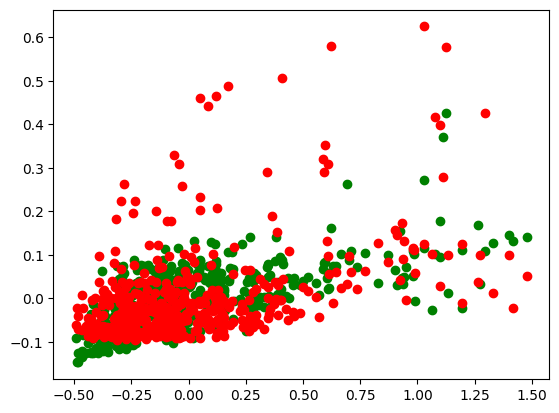

In [377]:
resqcorrelation, resqp_value = pearsonr(comparison_table['exp B-factor'], comparison_table['resq B-factor'])
print(f"The correlation coefficient for resq is: {resqcorrelation}")
print(f"The p-value is: {resqp_value}")
plt.scatter(comparison_table['exp B-factor'], comparison_table['resq B-factor'], c='g')

afcorrelation, afp_value = pearsonr(comparison_table['exp B-factor'], comparison_table['af B-factor'])
print(f"The correlation coefficient for AF2-score is: {afcorrelation}")
print(f"The p-value is: {afp_value}")
plt.scatter(comparison_table['exp B-factor'], comparison_table['af B-factor'], c='r')
plt.show